# NPCC Contingency Analysis

Reference:

1. Zhang, Q., Li, F. A Dataset for Electricity Market Studies on Western and Northeastern Power Grids in the United States. Sci Data 10, 646 (2023). https://doi.org/10.1038/s41597-023-02448-w
1. https://github.com/enliten/ENLITEN-Grid-Econ-Data/

In [1]:
from tqdm import tqdm

import numpy as np
import pandas as pd

import andes
import ams

import datetime

import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcdefaults()

In [3]:
%matplotlib inline

In [4]:
print("Last run time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

print(f'andes:{andes.__version__}')
print(f'ams:{ams.__version__}')

Last run time: 2024-04-10 16:16:16
andes:1.9.2
ams:0.9.5.post25+g738d558


In [5]:
andes.config_logger(stream_level=20)
ams.config_logger(stream_level=20)

In [6]:
ams_file = './data/npcc_uced_base.xlsx' # npcc_uced_base
andes_file = './data/npcc_ibr.xlsx' # npcc_ibr.xlsx, npcc_base.xlsx,

# 0.95, 1.1
k_load = 0.97  # load factor

out_file = './data/npcc_ibr_97_out.csv' # npcc_base_h_out.csv, npcc_ibr_h_out.csv
# ibr refers IBR with zero cost curve, while ibri refers IBR with same cost curve as base case

ad_case = out_file.split('/')[-1].split('.')[0].split('_')[1]

In [7]:
sp = ams.load(ams_file,
              setup=True,
              no_output=True,
              default_config=True,)

idx_pq = sp.PQ.idx.v
p0_pq = sp.PQ.p0.v.copy()
q0_pq = sp.PQ.q0.v.copy()

sp.PQ.alter(src='p0', idx=idx_pq, value=p0_pq * k_load)
sp.PQ.alter(src='q0', idx=idx_pq, value=q0_pq * k_load)

sa = sp.to_andes(addfile=andes_file,
                 setup=True, no_output=True, default_config=True)

tg_idx = sa.TGOV1NDB.idx.v
sa.TGOV1NDB.alter(src='VMAX', idx=tg_idx, value=999*np.ones(sa.TGOV1NDB.n))
sa.TGOV1NDB.alter(src='VMIN', idx=tg_idx, value=np.zeros(sa.TGOV1NDB.n))

iex_idx = sa.IEEEX1.idx.v
vrmax = sa.IEEEX1.VRMAX.v.copy()
vrmin = sa.IEEEX1.VRMIN.v.copy()
k_iex = 500
sa.IEEEX1.alter(src='VRMAX', idx=iex_idx, value=k_iex * vrmax)
sa.IEEEX1.alter(src='VRMIN', idx=iex_idx, value=k_iex * vrmin)

ist_idx = sa.IEEEST.idx.v
lsmax = sa.IEEEST.LSMAX.v.copy()
lsmin = sa.IEEEST.LSMIN.v.copy()
k_ist = 500
sa.IEEEST.alter(src='LSMAX', idx=ist_idx, value=k_ist * lsmax)
sa.IEEEST.alter(src='LSMIN', idx=ist_idx, value=k_ist * lsmin)

Working directory: "/Users/jinningwang/Documents/work/psal/src/notes/lmp"
Parsing input file "./data/npcc_uced_base.xlsx"...
Input file parsed in 0.2949 seconds.
Zero line rates detacted in rate_b, rate_c, adjusted to 999.
System set up in 0.0032 seconds.
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Parsing additional file "./data/npcc_ibr.xlsx"...
Following PFlow models in addfile will be overwritten: <Bus>, <PQ>, <PV>, <Slack>, <Line>, <Area>
Addfile parsed in 0.1714 seconds.
System converted to ANDES in 0.1680 seconds.
AMS system 0x105a95040 is linked to the ANDES system 0x16be413a0.
System internal structure set up in 0.0281 seconds.
<PFlow> initialized in 0.0053 seconds.
 0: |F(x)| = 1.393355502
 1: |F(x)| = 1.353411895
 2: |F(x)| = 0.02500957521
 3: |F(x)| = 1.385231783e-05
 4: |F(x)| = 8.849762214e-12
<PFlow> solved in 0.0177 seconds, converged in 4 iterations with PYPOWER-Newton.
-> System connectivity check results:
  No islanded bus detected.
  System

In [8]:
# for ibri, do not change the cost curve of VSG
if ad_case == 'ibr':
    vsg_idx = sa.REGCV1.gen.v
    gcost_vsg_idx = sp.GCost.find_idx(keys='gen', values=vsg_idx)
    sp.GCost.set(src='c2', attr='v', idx=gcost_vsg_idx, value=np.zeros(sa.REGCV1.n))
    sp.GCost.set(src='c1', attr='v', idx=gcost_vsg_idx, value=np.zeros(sa.REGCV1.n))
    sp.GCost.set(src='c0', attr='v', idx=gcost_vsg_idx, value=np.zeros(sa.REGCV1.n))

In [9]:
sp.RTED.init()

sp.RTED.run(solver='MOSEK')

sp.RTED.dc2ac()

sp.dyn.send(routine='RTED', adsys=sa)

<RTED> initialized in 0.0280 seconds.
<RTED> solved as optimal in 0.0640 seconds, converged in 12 iterations with MOSEK.
<ACOPF> initialized in 0.0053 seconds.
<ACOPF> solved in 0.8771 seconds, converged in 26 iterations with PYPOWER-PIPS.
<RTED> converted to AC.
Send <RTED> results to ANDES <0x16be413a0>...
*Send <vBus> to StaticGen.v0
Send <vBus> to Bus.v0
Send <ug> to StaticGen.u
Send <pg> to StaticGen.p0


True

In [10]:
sa.PQ.config.p2p = 0.999
sa.PQ.config.p2i = 0.0005
sa.PQ.config.p2z = 0.0005

sa.PQ.config.q2q = 0.999
sa.PQ.config.q2i = 0.0005
sa.PQ.config.q2z = 0.0005

sa.PQ.pq2z = 0

sa.PFlow.run()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0049 seconds.
0: |F(x)| = 19.76901258
1: |F(x)| = 4.63446606
2: |F(x)| = 0.4163645428
3: |F(x)| = 0.005446445729
4: |F(x)| = 2.233931362e-06
5: |F(x)| = 4.956035582e-13
Converged in 6 iterations in 0.0126 seconds.


True

In [11]:
_ = sa.TDS.init()

GENROU (vf range) out of typical lower limit.

   idx     | values | limit
-----------+--------+------
 GENROU_61 | 0.860  | 1    


GENROU (vf range) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_56 | 7.159  | 5    


Initialization for dynamics completed in 0.0620 seconds.
Initialization was successful.


In [12]:
sa.REGCV1.Pe.v.round(2)

array([17.94,  1.8 ,  3.34,  2.81])

In [13]:
{syg: sa.SynGen.get(src='Pe', attr='v', idx=syg, allow_none=True).round(3)
 for syg in sp.dyn.link['syg_idx'].dropna().tolist()}

{'GENCLS_78': 0.3,
 'GENROU_98': 1.025,
 'GENCLS_97': 8.0,
 'GENCLS_92': 8.0,
 'GENCLS_91': 8.0,
 'GENROU_86': 0.05,
 'GENROU_82': 0.05,
 'GENROU_80': 5.849,
 'GENROU_79': 0.05,
 'GENCLS_72': 0.05,
 'GENCLS_71': 10.398,
 'GENCLS_68': 0.05,
 'GENCLS_65': 0.05,
 'GENROU_61': 0.05,
 'GENROU_60': 0.05,
 'GENROU_57': 0.581,
 'GENROU_56': 20.086,
 'GENROU_55': 8.0,
 'GENROU_54_2': 8.0,
 'GENROU_54': 8.0,
 'GENCLS_53': 12.468,
 'GENROU_51': 0.05,
 'GENROU_50': 17.855,
 'GENROU_48': 0.401,
 'GENROU_47': 9.449,
 'GENROU_42': 0.05,
 'GENROU_36': 0.05,
 'GENROU_27': 15.359,
 'GENROU_24': 2.372,
 'GENROU_23_2': 1.815,
 'GENROU_22': 4.126,
 'GENCLS_139': 0.05,
 'GENCLS_137': 0.05,
 'GENCLS_135': 15.394,
 'GENCLS_134': 29.328,
 'GENCLS_133': 31.861,
 'GENCLS_130': 11.922,
 'GENCLS_123': 0.05,
 'GENCLS_122': 11.106,
 'GENCLS_121': 14.569,
 'GENCLS_120': 0.05,
 'GENCLS_119': 0.05,
 'GENCLS_115': 8.22,
 'GENROU_101': 8.0}

In [14]:
sa.TDS.config.criteria = True
sa.TDS.config.no_tqdm = False

sa.TDS.config.tf = 50
sa.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-50 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

<Toggle Toggler_1>: SynGen.GENCLS_68 status changed to 0 at t=1.0 sec.


Time step reduced to zero. Convergence is not likely.
Simulation terminated at t=3.2396 s.
Simulation to t=50.00 sec completed in 2.6500 seconds.


False

In [15]:
sa.TDS.reset()
sa.TDS.init()
sa.TDS.run()

GENROU (vf range) out of typical lower limit.

   idx     | values | limit
-----------+--------+------
 GENROU_61 | 0.860  | 1    


GENROU (vf range) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_56 | 7.159  | 5    


Suspect initialization issue! Simulation may crash!

     Name      | Var. Value | Eqn. Mismatch
---------------+------------+--------------
 a Bus 3       | 0.008      | 0.052        
 a Bus 6       | -0.269     | 2.064        
 a Bus 7       | -0.306     | 2.464        
 a Bus 9       | -0.218     | 0.968        
 a Bus 16      | 0.085      | 1.232        
 a Bus 17      | -0.200     | 1.019        
 a Bus 18      | -0.253     | 1.915        
 a Bus 19      | -0.286     | 1.867        
 a Bus 20      | -0.279     | 2.736        
 a Bus 30      | -0.121     | 1.748        
 a Bus 31      | -0.121     | 2.753        
 a Bus 34      | -0.079     | 1.354        
 a Bus 35      | -0.079     | 2.946        
 a Bus 126     | 0.25

  0%|          | 0/100 [00:00<?, ?%/s]

Time step reduced to zero. Convergence is not likely.
Simulation terminated at t=0.0000 s.
Simulation to t=50.00 sec completed in 1.8119 seconds.


False

TypeError: list indices must be integers or slices, not tuple

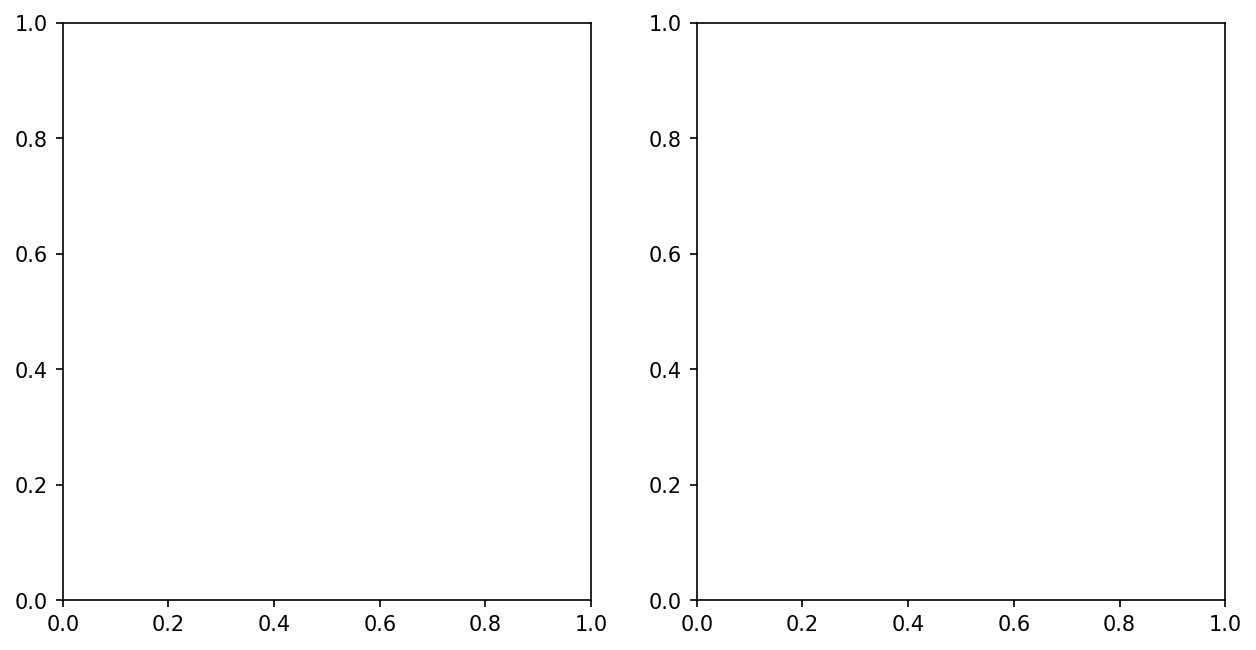

In [16]:
stg_idx = sp.dyn.link['stg_idx'].tolist()
stg_bus = sa.StaticGen.get(src='bus', attr='v', idx=stg_idx)
stg_bus_uid = sa.Bus.idx2uid(stg_bus)

busfreq_bus = sa.BusFreq.find_idx(keys='bus', values=stg_bus)
busfreq_bus_uid = sa.Bus.idx2uid(stg_bus)

Tf = sa.BusFreq.Tf.v.mean().round(3)
Tw = sa.BusFreq.Tw.v.mean().round(3)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=150)

fmin, fmax=59.95, 60.05
vmin, vmax=0.8, 1.4
trip_gen = sa.Toggle.dev.v[0]

sa.TDS.plt.plot(sa.GENCLS.omega,
                ax=ax[0], fig=fig,
                grid=True, show=False, legend=False,
                ytimes=sa.config.freq, ymin=fmin, ymax=fmax,
                title=f'{ad_case}, k_load={k_load}')
sa.TDS.plt.plot(sa.GENROU.omega,
                ax=ax[0], fig=fig,
                grid=True, show=False, legend=False,
                ytimes=sa.config.freq,)
sa.TDS.plt.plot(sa.REGCV1.omega,
                ax=ax[0], fig=fig,
                grid=True, show=False, legend=False,
                ytimes=sa.config.freq,)

sa.TDS.plt.plot(sa.Bus.v,
                a=stg_bus_uid,
                ax=ax[1], fig=fig,
                grid=True, show=False,
                ymin=vmin, ymax=vmax,
                title=f'Trip {trip_gen}')

In [ ]:
# sa.TDS.plt.export_csv(out_file)